# Time Series Decomposition - 1-Minute Resampling with Full Interpolation

This notebook performs MSTL decomposition with:
- 1-minute resampling (average of all values in each minute)
- Full interpolation of all gaps (no limit on gap size)
- Optional extreme outlier capping (only absurdly extreme values)
- Configurable seasonality patterns (daily, weekly, or both)
- All available data for the selected sensor

**Configuration:**
Edit the variables in Step 3 to customize:
- `selected_sensor`: Which sensor to analyze
- `patterns`: Which seasonality patterns to extract ('daily', 'weekly', or both)
- `cap_outliers`: Enable extreme outlier capping (recommended)
- `outlier_threshold`: Number of std deviations to consider extreme (default: 20)
- `use_robust`: Use robust MSTL mode (slower but handles outliers better)

**Steps**:
1. Imports
2. Load raw data
3. Configuration (EDIT THIS)
4. Select sensor
5. Preprocess Value column
6. Analyze gaps before resampling
7. Resample to 1-minute intervals
8. Interpolate all missing values
9. Cap extreme outliers (if enabled)
10. Apply MSTL decomposition
11. Visualize and save results

## Step 1: Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import json
from pathlib import Path

# Add SDK to path
SDK_PATH = Path().resolve().parents[2] / "src" / "sdk" / "python"
sys.path.insert(0, str(SDK_PATH))

from rtdip_sdk.pipelines.decomposition.pandas import MSTLDecomposition

print("Imports complete")

Imports complete


## Step 2: Load Raw Data

In [2]:
data_path = Path().resolve().parent / "data" / "ShellData.parquet"

print(f"Loading: {data_path}")
print(f"File exists: {data_path.exists()}")
print()

df = pd.read_parquet(data_path, columns=['TagName', 'EventTime', 'Value'])

print(f"Loaded {len(df):,} rows")
print(f"Memory: {df.memory_usage(deep=True).sum() / 1024 / 1024:.1f} MB")
print(f"Unique sensors: {df['TagName'].nunique():,}")
print()
df.head()

Loading: C:\Users\Agando\Documents\Projects\amos2025ws03-rtdip-timeseries-forecasting\amos_team_resources\shell\data\ShellData.parquet
File exists: True

Loaded 214,991,102 rows
Memory: 27188.6 MB
Unique sensors: 7,759



,TagName,EventTime,Value
0,A2PS64V0J.:ZUX09R,2024-01-02 20:03:46,0.34
1,A2PS64V0J.:ZUX09R,2024-01-02 16:00:12,0.15
2,A2PS64V0J.:ZUX09R,2024-01-02 11:56:42,0.13
3,A2PS64V0J.:ZUX09R,2024-01-02 07:53:11,0.12
4,A2PS64V0J.:ZUX09R,2024-01-02 03:49:45,0.13


## Step 3: Configuration (EDIT THIS)

Configure the decomposition parameters here:

In [ ]:
# ============================================================================
# CONFIGURATION - Edit these variables to customize the decomposition
# ============================================================================

# Sensor selection
selected_sensor = "0SP116X5V:NXR.0"

# Seasonality patterns to extract
# Options: ['daily'], ['weekly'], or ['daily', 'weekly']
patterns = ['daily', 'weekly']

# Extreme outlier capping (recommended to prevent decomposition distortion)
# Only caps values beyond outlier_threshold standard deviations
cap_outliers = True
outlier_threshold = 20.0  # Number of std deviations (20 catches only absurdly extreme values)

# MSTL robust mode (slower but more resistant to outliers)
# Usually not needed if cap_outliers is enabled
use_robust = False

# ============================================================================

print("Configuration:")
print(f"  Sensor: {selected_sensor}")
print(f"  Patterns: {patterns}")
print(f"  Cap outliers: {cap_outliers}")
if cap_outliers:
    print(f"    Threshold: {outlier_threshold} standard deviations")
print(f"  Robust mode: {use_robust}")
print()
print("Ready to proceed with decomposition")

## Step 4: Select Sensor

In [ ]:
print(f"Filtering to sensor: {selected_sensor}")
df_sensor = df[df['TagName'] == selected_sensor].copy()

print(f"Selected sensor has {len(df_sensor):,} rows ({len(df_sensor)/len(df)*100:.2f}% of total)")

del df

df_sensor.head()

## Step 5: Preprocess Value Column

In [4]:
print("Preprocessing...")
print()

# Convert EventTime
print("Converting EventTime to datetime...")
df_sensor['EventTime'] = pd.to_datetime(df_sensor['EventTime'], errors='coerce')
invalid_times = df_sensor['EventTime'].isna().sum()
if invalid_times > 0:
    df_sensor = df_sensor.dropna(subset=['EventTime']).copy()
    print(f"  Dropped {invalid_times:,} invalid timestamps")
else:
    print(f"  All timestamps valid")
print()

# Convert Value to numeric
print("Converting Value to numeric...")
if not pd.api.types.is_numeric_dtype(df_sensor['Value']):
    df_sensor['Value'] = pd.to_numeric(df_sensor['Value'], errors='coerce')
    print(f"  Converted to numeric")
else:
    print(f"  Already numeric")
print()

# Remove invalid values
print("Removing NaN and error values (-1)...")
before_len = len(df_sensor)
df_sensor = df_sensor[
    (df_sensor['Value'].notna()) & 
    (df_sensor['Value'] != -1)
].copy()
removed = before_len - len(df_sensor)
print(f"  Removed {removed:,} rows ({removed/before_len*100:.2f}%)")
print(f"  Remaining: {len(df_sensor):,} rows")
print()

# Sort by time
df_sensor = df_sensor.sort_values('EventTime').reset_index(drop=True)
print("Sorted by time")
print()

print(f"Time range: {df_sensor['EventTime'].min()} to {df_sensor['EventTime'].max()}")
print(f"Duration: {df_sensor['EventTime'].max() - df_sensor['EventTime'].min()}")
print()
print("Value statistics:")
print(df_sensor['Value'].describe())

Preprocessing...

Converting EventTime to datetime...
  All timestamps valid

Converting Value to numeric...
  Converted to numeric

Removing NaN and error values (-1)...
  Removed 83 rows (0.02%)
  Remaining: 380,220 rows

Sorted by time

Time range: 2024-01-30 00:00:12 to 2024-02-28 19:48:12
Duration: 29 days 19:48:00

Value statistics:
count    380220.000000
mean         -0.410072
std           0.473329
min          -2.807080
25%          -0.541971
50%          -0.434058
75%          -0.299673
max         249.000000
Name: Value, dtype: float64


## Step 6: Analyze Original Sampling Pattern

In [5]:
print("Analyzing original sampling intervals...")
print("="*80)

time_diffs = df_sensor['EventTime'].diff().dropna()

print("\nSampling statistics:")
print(f"  Median:  {time_diffs.median()}")
print(f"  Mean:    {time_diffs.mean()}")
print(f"  Min:     {time_diffs.min()}")
print(f"  Max:     {time_diffs.max()}")
print()
print("Percentiles:")
for p in [25, 50, 75, 90, 95, 99]:
    print(f"  {p:2d}th: {time_diffs.quantile(p/100)}")

# Find large gaps
median_interval = time_diffs.median()
gap_threshold = median_interval * 10
gaps = time_diffs[time_diffs > gap_threshold]

print(f"\nGaps larger than {gap_threshold}: {len(gaps)}")
if len(gaps) > 0:
    print("\nLargest 5 gaps:")
    for i, (idx, gap_size) in enumerate(gaps.nlargest(5).items(), 1):
        gap_start = df_sensor.loc[idx-1, 'EventTime']
        gap_end = df_sensor.loc[idx, 'EventTime']
        print(f"  {i}. {gap_size} from {gap_start} to {gap_end}")

Analyzing original sampling intervals...

Sampling statistics:
  Median:  0 days 00:00:05
  Mean:    0 days 00:00:06.777357259
  Min:     0 days 00:00:00.001000
  Max:     0 days 03:37:00

Percentiles:
  25th: 0 days 00:00:05
  50th: 0 days 00:00:05
  75th: 0 days 00:00:05
  90th: 0 days 00:00:16.999000
  95th: 0 days 00:00:16.999000
  99th: 0 days 00:00:54

Gaps larger than 0 days 00:00:50: 9050

Largest 5 gaps:
  1. 0 days 03:37:00 from 2024-02-12 20:23:12 to 2024-02-13 00:00:12
  2. 0 days 03:24:20.001000 from 2024-02-14 17:30:00.001000 to 2024-02-14 20:54:20.002000
  3. 0 days 03:05:26.999000 from 2024-02-14 20:54:45.001000 to 2024-02-15 00:00:12
  4. 0 days 02:59:53.575000 from 2024-02-02 07:47:18.425000 to 2024-02-02 10:47:12
  5. 0 days 02:28:00 from 2024-02-05 21:32:12 to 2024-02-06 00:00:12


## Step 7: Resample to 1-Minute Intervals

Resampling aggregates all values within each 1-minute bin using the mean.

In [6]:
print("Resampling to 1-minute intervals...")
print("="*80)

resample_freq = '1T'  # 1 minute
print(f"Resampling frequency: {resample_freq} (1 minute)")
print(f"Aggregation: mean (average of all values in each minute)")
print()

# Resample
df_resampled = df_sensor.set_index('EventTime').resample(resample_freq)['Value'].mean().reset_index()

print(f"Original points: {len(df_sensor):,}")
print(f"Resampled to: {len(df_resampled):,} 1-minute intervals")
print()

# Check missing values
missing_count = df_resampled['Value'].isna().sum()
print(f"Missing values after resampling: {missing_count:,} ({missing_count/len(df_resampled)*100:.2f}%)")

if missing_count > 0:
    # Analyze gap distribution
    is_nan = df_resampled['Value'].isna()
    nan_groups = (is_nan != is_nan.shift()).cumsum()
    nan_sequences = df_resampled[is_nan].groupby(nan_groups).size()
    
    print(f"\nGap analysis:")
    print(f"  Number of gaps: {len(nan_sequences)}")
    print(f"  Smallest gap: {nan_sequences.min()} minutes")
    print(f"  Largest gap: {nan_sequences.max()} minutes ({nan_sequences.max()/60:.1f} hours)")
    print(f"  Mean gap: {nan_sequences.mean():.1f} minutes")
    print(f"  Median gap: {nan_sequences.median():.0f} minutes")

df_resampled.head(10)

Resampling to 1-minute intervals...
Resampling frequency: 1T (1 minute)
Aggregation: mean (average of all values in each minute)

Original points: 380,220
Resampled to: 42,949 1-minute intervals

Missing values after resampling: 1,484 (3.46%)

Gap analysis:
  Number of gaps: 18
  Smallest gap: 1 minutes
  Largest gap: 216 minutes (3.6 hours)
  Mean gap: 82.4 minutes
  Median gap: 69 minutes


C:\Users\Agando\AppData\Local\Temp\ipykernel_16472\3675460017.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df_sensor.set_index('EventTime').resample(resample_freq)['Value'].mean().reset_index()


,EventTime,Value
0,2024-01-30 00:00:00,-0.274511
1,2024-01-30 00:01:00,-0.228301
2,2024-01-30 00:02:00,-0.219824
3,2024-01-30 00:03:00,-0.190752
4,2024-01-30 00:04:00,-0.218683
5,2024-01-30 00:05:00,-0.272466
6,2024-01-30 00:06:00,-0.266900
7,2024-01-30 00:07:00,-0.239333
8,2024-01-30 00:08:00,-0.220917
9,2024-01-30 00:09:00,-0.297519


## Step 8: Interpolate All Missing Values

Using time-based interpolation which accounts for the actual time duration of gaps.

In [7]:
print("Interpolating all missing values...")
print("="*80)

missing_before = df_resampled['Value'].isna().sum()
print(f"Missing values before interpolation: {missing_before:,}")
print(f"Interpolation method: time-based (accounts for gap duration)")
print(f"Limit: None (interpolate all gaps)")
print()

# Set index for time-based interpolation
df_interpolated = df_resampled.set_index('EventTime')

# Interpolate with time method
df_interpolated['Value'] = df_interpolated['Value'].interpolate(
    method='time',
    limit_direction='both'
)

df_interpolated = df_interpolated.reset_index()

# Check results
missing_after = df_interpolated['Value'].isna().sum()
interpolated_count = missing_before - missing_after

print(f"Interpolated: {interpolated_count:,} values ({interpolated_count/len(df_interpolated)*100:.2f}%)")
print(f"Remaining NaN: {missing_after:,}")

if missing_after > 0:
    print(f"\nWarning: {missing_after} values still missing (likely at start/end)")
    print("Removing remaining NaN values...")
    df_interpolated = df_interpolated.dropna(subset=['Value']).reset_index(drop=True)
    print(f"Final dataset: {len(df_interpolated):,} rows")

print(f"\nComplete dataset with no gaps: {df_interpolated['Value'].notna().all()}")

Interpolating all missing values...
Missing values before interpolation: 1,484
Interpolation method: time-based (accounts for gap duration)
Limit: None (interpolate all gaps)

Interpolated: 1,484 values (3.46%)
Remaining NaN: 0

Complete dataset with no gaps: True


## Step 9: Visualize Before/After Interpolation

Compare original data points vs resampled + interpolated data

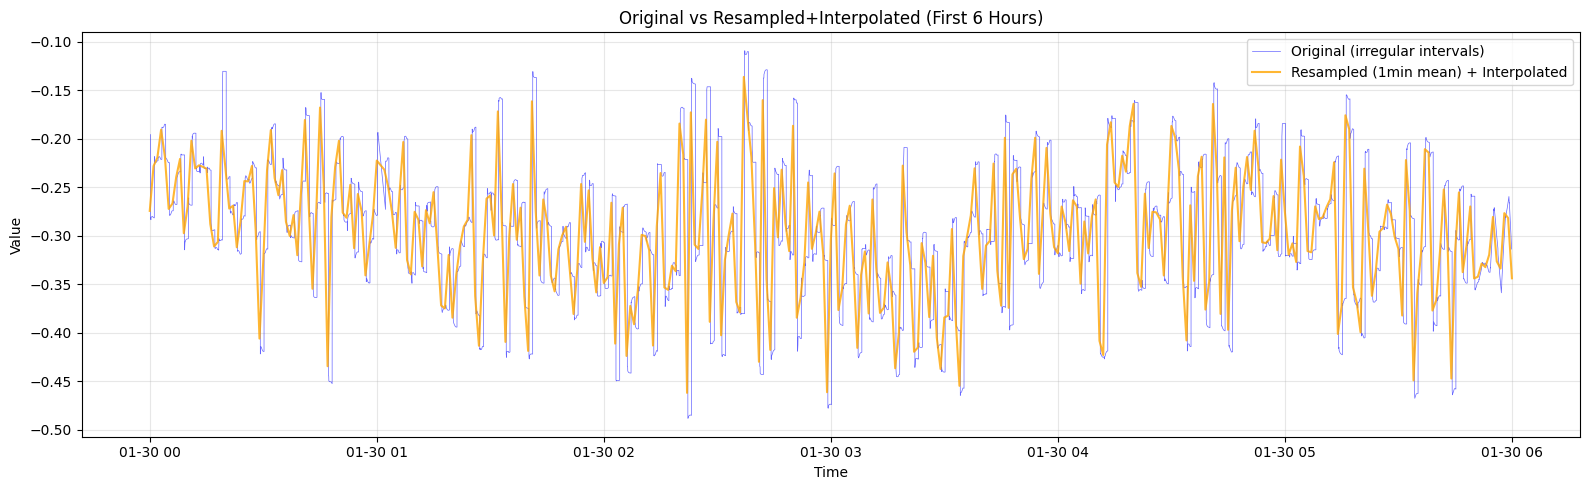

Original data: 3,905 points (irregular intervals)
Resampled data: 361 points (regular 1-minute intervals)
\nVariance comparison:
  Original: 0.004910
  Resampled: 0.004183
  Reduction: 14.8%


In [8]:
# Take a 6-hour window to see detail
start_time = df_interpolated['EventTime'].min()
window_end = start_time + pd.Timedelta(hours=6)

# Filter data
original_window = df_sensor[(df_sensor['EventTime'] >= start_time) & (df_sensor['EventTime'] <= window_end)]
interpolated_window = df_interpolated[(df_interpolated['EventTime'] >= start_time) & (df_interpolated['EventTime'] <= window_end)]

fig, ax = plt.subplots(figsize=(16, 5))

# Both as lines to compare variance
ax.plot(original_window['EventTime'], original_window['Value'], 
        linewidth=0.5, alpha=0.6, label='Original (irregular intervals)', color='blue')
ax.plot(interpolated_window['EventTime'], interpolated_window['Value'], 
        linewidth=1.5, alpha=0.8, label='Resampled (1min mean) + Interpolated', color='orange')

ax.set_title(f'Original vs Resampled+Interpolated (First 6 Hours)')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('interpolation_comparison.png', dpi=150)
plt.show()

print(f"Original data: {len(original_window):,} points (irregular intervals)")
print(f"Resampled data: {len(interpolated_window):,} points (regular 1-minute intervals)")
print(f"\\nVariance comparison:")
print(f"  Original: {original_window['Value'].var():.6f}")
print(f"  Resampled: {interpolated_window['Value'].var():.6f}")
print(f"  Reduction: {(1 - interpolated_window['Value'].var()/original_window['Value'].var())*100:.1f}%")

## Step 9: All Available Data Info

In [9]:
print("Using all available data...")
print("="*80)

# Use full dataset
df_full = df_interpolated.copy()

start_time = df_full['EventTime'].min()
end_time = df_full['EventTime'].max()
total_duration = end_time - start_time

print(f"Full dataset:")
print(f"  Start: {start_time}")
print(f"  End: {end_time}")
print(f"  Duration: {total_duration}")
print(f"  Days: {total_duration.days + total_duration.seconds/(24*3600):.1f}")
print(f"  Points: {len(df_full):,}")
print()

# Calculate periods (1-minute resampling)
daily_period = 60 * 24  # 1440 minutes per day
weekly_period = 60 * 24 * 7  # 10080 minutes per week

print(f"Periods for MSTL:")
print(f"  Daily: {daily_period} observations (24 hours)")
print(f"  Weekly: {weekly_period} observations (7 days)")
print()

# Check sufficiency
min_required_daily = daily_period * 2
min_required_weekly = weekly_period * 2

print(f"Data requirements:")
print(f"  For daily pattern: need >= {min_required_daily:,} points (2 days)")
print(f"  For weekly pattern: need >= {min_required_weekly:,} points (14 days)")
print(f"  Available: {len(df_full):,} points")
print()

if len(df_full) >= min_required_weekly:
    print(f"Sufficient data for both daily and weekly patterns")
    use_weekly = True
elif len(df_full) >= min_required_daily:
    print(f"Sufficient data for daily pattern only (not enough for weekly)")
    use_weekly = False
else:
    print(f"Insufficient data for decomposition")
    use_weekly = False

Using all available data...
Full dataset:
  Start: 2024-01-30 00:00:00
  End: 2024-02-28 19:48:00
  Duration: 29 days 19:48:00
  Days: 29.8
  Points: 42,949

Periods for MSTL:
  Daily: 1440 observations (24 hours)
  Weekly: 10080 observations (7 days)

Data requirements:
  For daily pattern: need >= 2,880 points (2 days)
  For weekly pattern: need >= 20,160 points (14 days)
  Available: 42,949 points

Sufficient data for both daily and weekly patterns


## Step 10: Visualize Data Before Decomposition

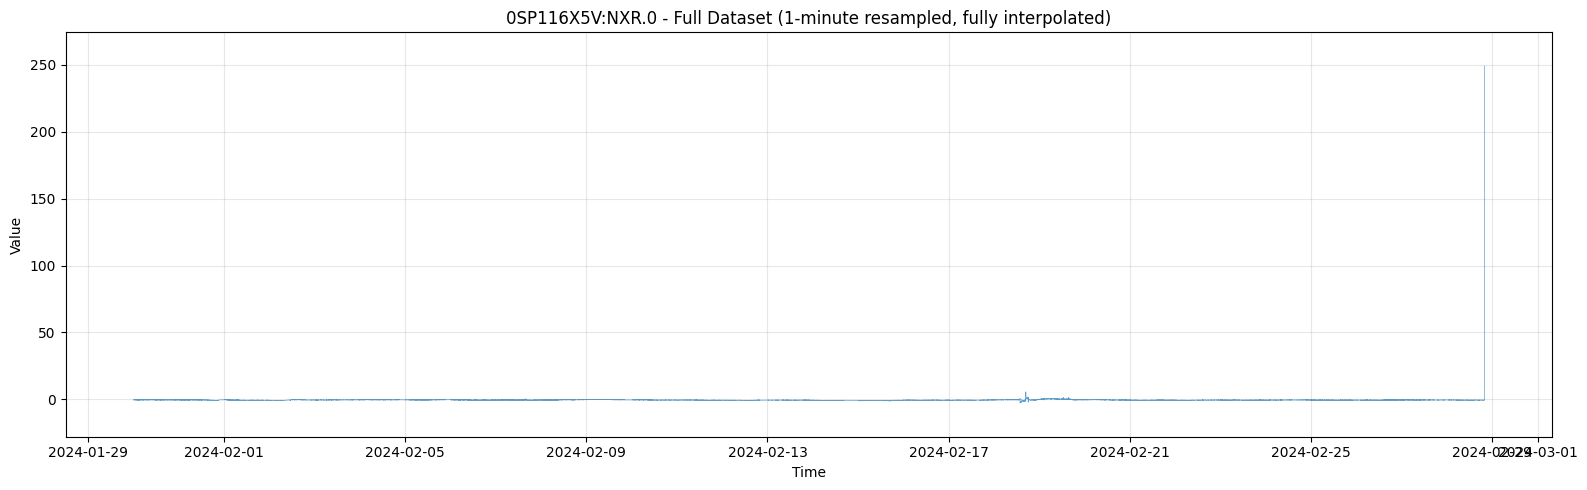

Data characteristics:
  Mean: -0.4204
  Std: 1.2260
  Min: -2.6679
  Max: 249.0000
  Range: 251.6679


In [10]:
fig, ax = plt.subplots(figsize=(16, 5))

ax.plot(df_full['EventTime'], df_full['Value'], linewidth=0.5, alpha=0.7)
ax.set_title(f'{selected_sensor} - Full Dataset (1-minute resampled, fully interpolated)')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.grid(True, alpha=0.3)

# Set y-axis limits based on actual data range with some padding
value_min = df_full['Value'].min()
value_max = df_full['Value'].max()
value_range = value_max - value_min
padding = value_range * 0.1  # 10% padding
ax.set_ylim(value_min - padding, value_max + padding)

plt.tight_layout()
plt.savefig('data_before_decomposition.png', dpi=150)
plt.show()

print(f"Data characteristics:")
print(f"  Mean: {df_full['Value'].mean():.4f}")
print(f"  Std: {df_full['Value'].std():.4f}")
print(f"  Min: {df_full['Value'].min():.4f}")
print(f"  Max: {df_full['Value'].max():.4f}")
print(f"  Range: {value_range:.4f}")

## Step 10: Cap Extreme Outliers (Optional)

Only caps absurdly extreme outliers (beyond `outlier_threshold` standard deviations) to prevent them from distorting the seasonal patterns. This uses a two-stage approach:
1. Identifies values beyond the std deviation threshold
2. Among those, caps to 0.1st/99.9th percentiles

This preserves natural variation while removing sensor malfunctions.

In [ ]:
if cap_outliers:
    print("Checking for extreme outliers...")
    print("="*80)
    
    mean = df_full['Value'].mean()
    std = df_full['Value'].std()
    
    # Stage 1: Identify absurdly extreme values (beyond n_std standard deviations)
    lower_extreme = mean - outlier_threshold * std
    upper_extreme = mean + outlier_threshold * std
    
    extreme_mask = (df_full['Value'] < lower_extreme) | (df_full['Value'] > upper_extreme)
    extreme_count = extreme_mask.sum()
    
    print(f"Data statistics:")
    print(f"  Mean: {mean:.4f}")
    print(f"  Std: {std:.4f}")
    print(f"Extreme outlier threshold ({outlier_threshold} std):")
    print(f"  Lower: {lower_extreme:.4f}")
    print(f"  Upper: {upper_extreme:.4f}")
    print(f"Found {extreme_count} extreme outliers ({extreme_count/len(df_full)*100:.3f}%)")
    print()
    
    if extreme_count > 0:
        # Stage 2: For extreme outliers, cap to percentiles
        q99_9 = df_full['Value'].quantile(0.999)
        q00_1 = df_full['Value'].quantile(0.001)
        
        # Only cap values that are BOTH extreme (beyond n_std) AND beyond percentiles
        cap_lower = (df_full['Value'] < lower_extreme) & (df_full['Value'] < q00_1)
        cap_upper = (df_full['Value'] > upper_extreme) & (df_full['Value'] > q99_9)
        outliers_total = cap_lower.sum() + cap_upper.sum()
        
        print(f"Capping thresholds:")
        print(f"  Lower (0.1st percentile): {q00_1:.4f}")
        print(f"  Upper (99.9th percentile): {q99_9:.4f}")
        print(f"Values to cap: {outliers_total}")
        print()
        
        if outliers_total > 0:
            # Show most extreme values
            extreme_values = df_full[extreme_mask].copy()
            extreme_high = extreme_values.nlargest(min(5, len(extreme_values)), 'Value')
            extreme_low = extreme_values.nsmallest(min(5, len(extreme_values)), 'Value')
            
            if len(extreme_high) > 0:
                print("Most extreme high values:")
                for idx, row in extreme_high.iterrows():
                    print(f"  {row['EventTime']}: {row['Value']:.4f} (>{upper_extreme:.1f})")
            
            if len(extreme_low) > 0 and extreme_low['Value'].min() < lower_extreme:
                print("Most extreme low values:")
                for idx, row in extreme_low.iterrows():
                    if row['Value'] < lower_extreme:
                        print(f"  {row['EventTime']}: {row['Value']:.4f} (<{lower_extreme:.1f})")
            print()
            
            # Cap the values
            df_full['Value'] = df_full['Value'].clip(lower=q00_1, upper=q99_9)
            
            print(f"After capping:")
            print(f"  Min: {df_full['Value'].min():.4f}")
            print(f"  Max: {df_full['Value'].max():.4f}")
            
            outlier_metadata = {
                'method': 'std_deviation + percentile',
                'std_threshold': outlier_threshold,
                'lower_percentile': 0.001,
                'upper_percentile': 0.999,
                'outliers_capped': int(outliers_total)
            }
        else:
            print("No values need capping")
            outlier_metadata = {
                'method': 'std_deviation + percentile',
                'std_threshold': outlier_threshold,
                'outliers_capped': 0
            }
    else:
        print("No extreme outliers to cap")
        outlier_metadata = {
            'method': 'std_deviation + percentile',
            'std_threshold': outlier_threshold,
            'outliers_capped': 0
        }
else:
    print("Skipping outlier capping (cap_outliers=False)")
    outlier_metadata = {
        'method': 'none',
        'outliers_capped': 0
    }

In [12]:
# Investigate outliers in the data
print("Outlier Investigation")
print("="*80)

# Find extreme values
q1 = df_full['Value'].quantile(0.25)
q3 = df_full['Value'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 3 * iqr
upper_bound = q3 + 3 * iqr

outliers = df_full[(df_full['Value'] < lower_bound) | (df_full['Value'] > upper_bound)]

print(f"IQR-based outlier detection:")
print(f"  Q1: {q1:.4f}")
print(f"  Q3: {q3:.4f}")
print(f"  IQR: {iqr:.4f}")
print(f"  Lower bound (Q1 - 3*IQR): {lower_bound:.4f}")
print(f"  Upper bound (Q3 + 3*IQR): {upper_bound:.4f}")
print()
print(f"Found {len(outliers)} outliers ({len(outliers)/len(df_full)*100:.3f}%)")
print()

if len(outliers) > 0:
    print("Top 10 outliers by absolute deviation from median:")
    median = df_full['Value'].median()
    outliers_sorted = outliers.copy()
    outliers_sorted['abs_dev'] = (outliers_sorted['Value'] - median).abs()
    outliers_sorted = outliers_sorted.sort_values('abs_dev', ascending=False)
    
    for i, (idx, row) in enumerate(outliers_sorted.head(10).iterrows(), 1):
        print(f"  {i}. Time: {row['EventTime']}, Value: {row['Value']:.4f}, Deviation: {row['abs_dev']:.4f}")
    
    print()
    print(f"Outlier statistics:")
    print(f"  Min: {outliers['Value'].min():.4f}")
    print(f"  Max: {outliers['Value'].max():.4f}")
    print(f"  Mean: {outliers['Value'].mean():.4f}")
    print(f"  Median: {outliers['Value'].median():.4f}")

Outlier Investigation
IQR-based outlier detection:
  Q1: -0.5530
  Q3: -0.3148
  IQR: 0.2382
  Lower bound (Q1 - 3*IQR): -1.2677
  Upper bound (Q3 + 3*IQR): 0.3999

Found 549 outliers (1.278%)

Top 10 outliers by absolute deviation from median:
  1. Time: 2024-02-28 19:48:00, Value: 0.9962, Deviation: 1.4457
  2. Time: 2024-02-18 16:52:00, Value: 0.9962, Deviation: 1.4457
  3. Time: 2024-02-18 17:00:00, Value: 0.9962, Deviation: 1.4457
  4. Time: 2024-02-18 16:59:00, Value: 0.9962, Deviation: 1.4457
  5. Time: 2024-02-18 16:58:00, Value: 0.9962, Deviation: 1.4457
  6. Time: 2024-02-18 16:57:00, Value: 0.9962, Deviation: 1.4457
  7. Time: 2024-02-18 16:56:00, Value: 0.9962, Deviation: 1.4457
  8. Time: 2024-02-18 16:55:00, Value: 0.9962, Deviation: 1.4457
  9. Time: 2024-02-18 16:54:00, Value: 0.9962, Deviation: 1.4457
  10. Time: 2024-02-18 16:53:00, Value: 0.9962, Deviation: 1.4457

Outlier statistics:
  Min: -1.6219
  Max: 0.9962
  Mean: 0.2808
  Median: 0.4756


## Step 11: Apply MSTL Decomposition

In [ ]:
print("Applying MSTL Decomposition...")
print("="*80)

# Calculate periods for 1-minute resampling
daily_period = 60 * 24  # 1440 minutes per day
weekly_period = 60 * 24 * 7  # 10080 minutes per week

# Map pattern names to periods
pattern_map = {
    'daily': daily_period,
    'weekly': weekly_period
}

# Build periods list from requested patterns
periods = []
use_weekly = False

for pattern in patterns:
    if pattern not in pattern_map:
        raise ValueError(f"Unknown pattern '{pattern}'. Valid: {list(pattern_map.keys())}")
    
    period = pattern_map[pattern]
    
    # Check data sufficiency
    min_required = period * 2
    if len(df_full) < min_required:
        print(f"Warning: Insufficient data for {pattern} pattern")
        print(f"  Need: {min_required:,} points, Have: {len(df_full):,} points")
        print(f"  Skipping {pattern} pattern")
        continue
    
    periods.append(period)
    if pattern == 'weekly':
        use_weekly = True

if len(periods) == 0:
    raise ValueError("No valid patterns available for decomposition (insufficient data)")

pattern_names = [k for k, v in pattern_map.items() if v in periods]
print(f"Using patterns: {', '.join(pattern_names)}")
print(f"Data points: {len(df_full):,}")
print(f"Periods: {periods}")
print(f"Robust mode: {use_robust}")
print()

try:
    print("Creating MSTL decomposer...")
    mstl = MSTLDecomposition(
        df=df_full,
        value_column='Value',
        timestamp_column='EventTime',
        periods=periods,
        iterate=2,
        stl_kwargs={'robust': use_robust}
    )
    
    print("Decomposing (this may take several minutes for large datasets)...")
    df_decomposed = mstl.decompose()
    
    print("\nDecomposition successful")
    print(f"\nComponents:")
    for col in df_decomposed.columns:
        if col not in ['EventTime', 'Value']:
            print(f"  - {col}")
    
    print(f"\nShape: {df_decomposed.shape}")
    
except Exception as e:
    print(f"\nDecomposition failed")
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()
    df_decomposed = None

## Step 12: Visualize Decomposition

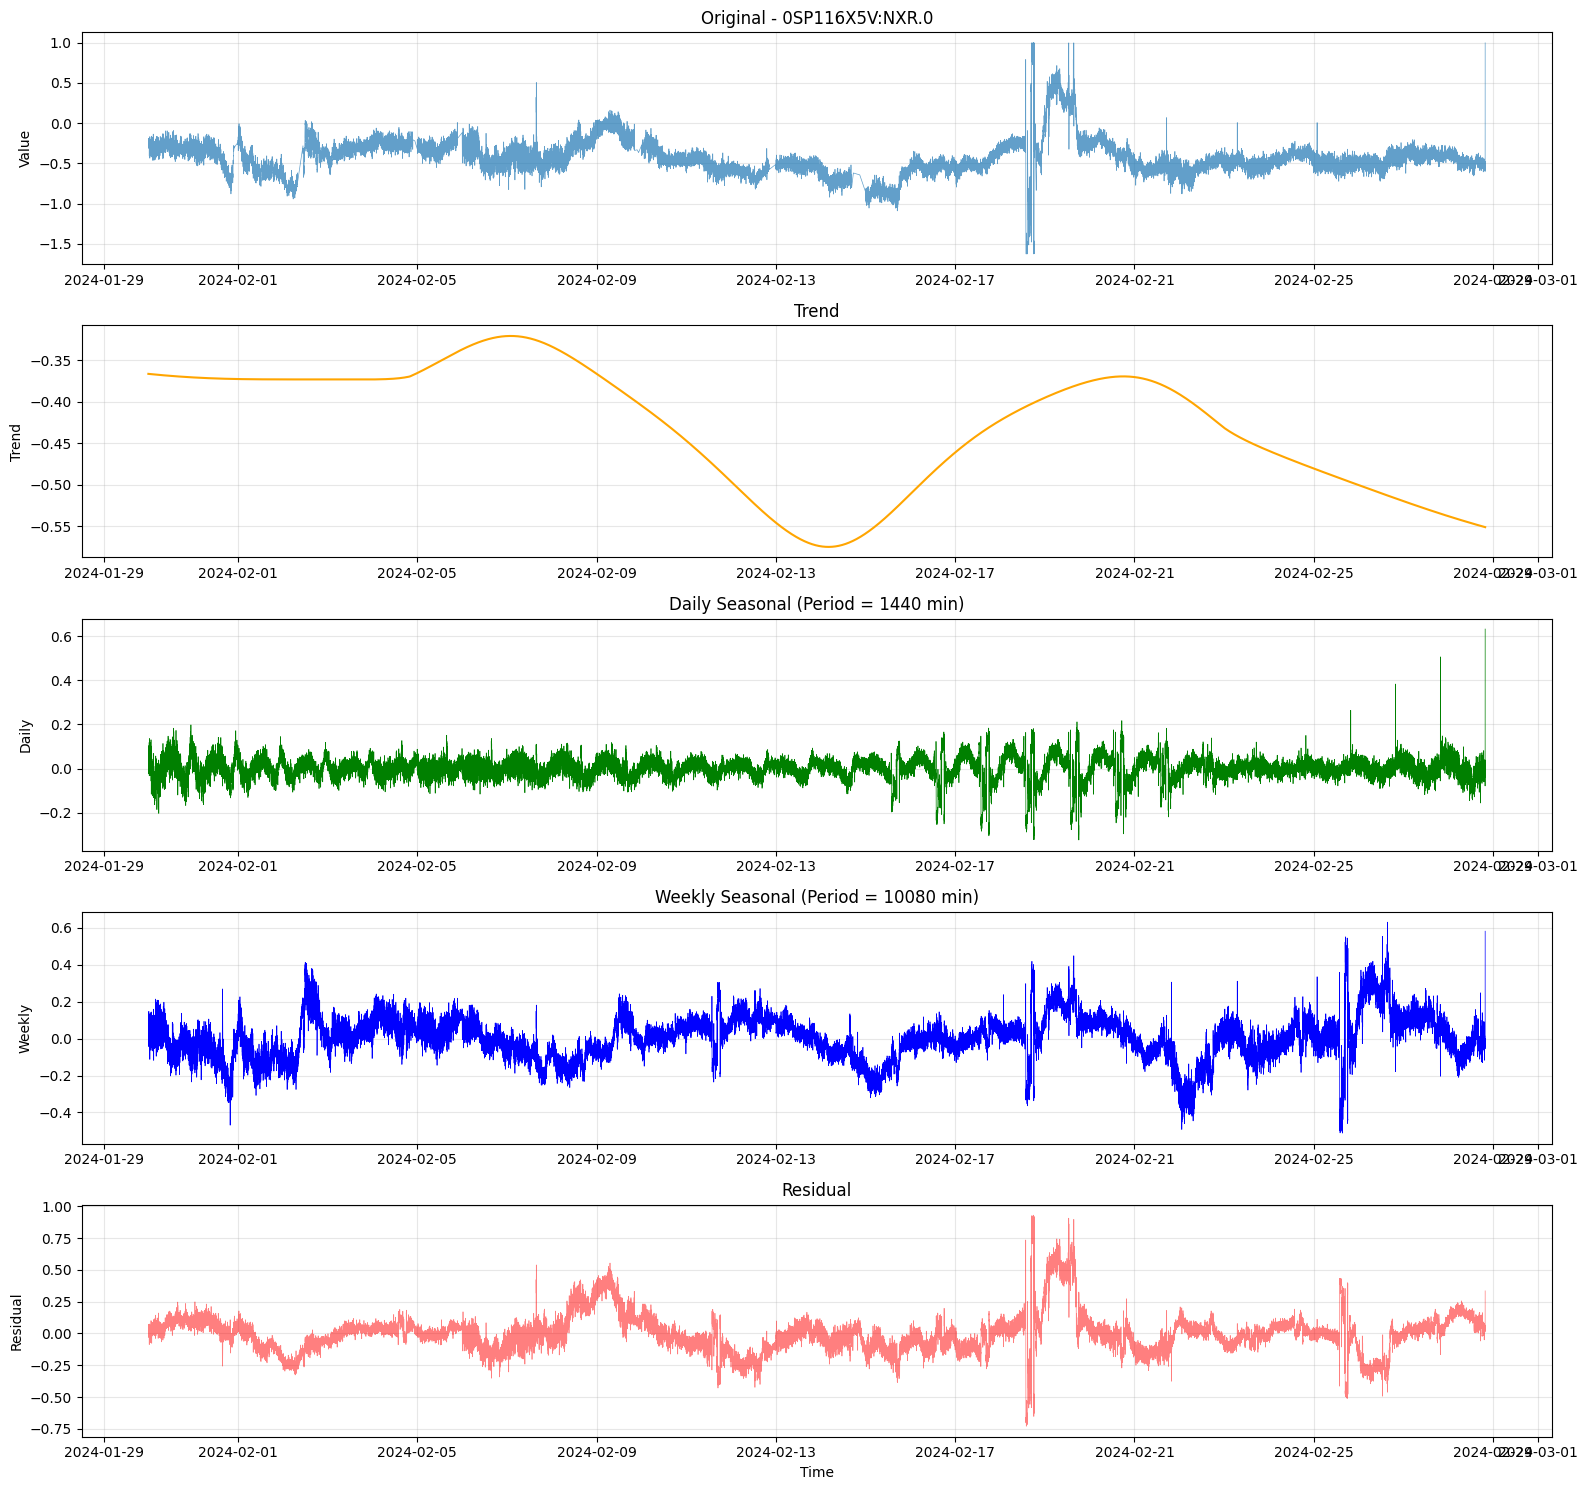

In [14]:
if df_decomposed is not None:
    daily_col = f'seasonal_{daily_period}'
    weekly_col = f'seasonal_{weekly_period}' if use_weekly else None
    
    n_plots = 5 if use_weekly else 4
    fig, axes = plt.subplots(n_plots, 1, figsize=(16, 3*n_plots))
    
    idx = 0
    
    # Helper function to set outlier-aware y-axis limits
    def set_outlier_aware_ylim(ax, data):
        p1 = data.quantile(0.01)
        p99 = data.quantile(0.99)
        value_range = p99 - p1
        padding = value_range * 0.1
        ax.set_ylim(p1 - padding, p99 + padding)
    
    # Original
    axes[idx].plot(df_decomposed['EventTime'], df_decomposed['Value'], linewidth=0.5, alpha=0.7)
    axes[idx].set_title(f'Original - {selected_sensor}')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(True, alpha=0.3)
    #set_outlier_aware_ylim(axes[idx], df_decomposed['Value'])
    idx += 1
    
    # Trend
    axes[idx].plot(df_decomposed['EventTime'], df_decomposed['trend'], linewidth=1.5, color='orange')
    axes[idx].set_title('Trend')
    axes[idx].set_ylabel('Trend')
    axes[idx].grid(True, alpha=0.3)
    #set_outlier_aware_ylim(axes[idx], df_decomposed['trend'].dropna())
    idx += 1
    
    # Daily seasonal
    axes[idx].plot(df_decomposed['EventTime'], df_decomposed[daily_col], linewidth=0.5, color='green')
    axes[idx].set_title(f'Daily Seasonal (Period = {daily_period} min)')
    axes[idx].set_ylabel('Daily')
    axes[idx].grid(True, alpha=0.3)
    #set_outlier_aware_ylim(axes[idx], df_decomposed[daily_col].dropna())
    idx += 1
    
    # Weekly seasonal (if applicable)
    if use_weekly:
        axes[idx].plot(df_decomposed['EventTime'], df_decomposed[weekly_col], linewidth=0.5, color='blue')
        axes[idx].set_title(f'Weekly Seasonal (Period = {weekly_period} min)')
        axes[idx].set_ylabel('Weekly')
        axes[idx].grid(True, alpha=0.3)
        #set_outlier_aware_ylim(axes[idx], df_decomposed[weekly_col].dropna())
        idx += 1
    
    # Residual
    axes[idx].plot(df_decomposed['EventTime'], df_decomposed['residual'], linewidth=0.5, color='red', alpha=0.5)
    axes[idx].set_title('Residual')
    axes[idx].set_xlabel('Time')
    axes[idx].set_ylabel('Residual')
    axes[idx].grid(True, alpha=0.3)
    #set_outlier_aware_ylim(axes[idx], df_decomposed['residual'].dropna())
    
    plt.tight_layout()
    safe_tag = selected_sensor.replace('/', '_').replace('\\', '_').replace(':', '_')
    plt.savefig(f'decomposition_{safe_tag}_1min_full.png', dpi=150)
    plt.show()
else:
    print("Cannot visualize - decomposition failed")

In [15]:
if df_decomposed is not None:
    print("Decomposition Component Outlier Analysis")
    print("="*80)
    
    daily_col = f'seasonal_{daily_period}'
    weekly_col = f'seasonal_{weekly_period}' if use_weekly else None
    
    components = {
        'Original': df_decomposed['Value'],
        'Trend': df_decomposed['trend'].dropna(),
        'Daily Seasonal': df_decomposed[daily_col].dropna(),
        'Residual': df_decomposed['residual'].dropna()
    }
    
    if use_weekly:
        components['Weekly Seasonal'] = df_decomposed[weekly_col].dropna()
    
    for name, data in components.items():
        q1 = data.quantile(0.01)
        q99 = data.quantile(0.99)
        min_val = data.min()
        max_val = data.max()
        median = data.median()
        
        print(f"\n{name}:")
        print(f"  Min: {min_val:.4f}")
        print(f"  1st percentile: {q1:.4f}")
        print(f"  Median: {median:.4f}")
        print(f"  99th percentile: {q99:.4f}")
        print(f"  Max: {max_val:.4f}")
        print(f"  Range (max-min): {max_val - min_val:.4f}")
        print(f"  Range (p99-p1): {q99 - q1:.4f}")
        
        if max_val > q99 * 10 or min_val < q1 * 10:
            print(f"  WARNING: Extreme outliers detected!")
else:
    print("Cannot analyze - decomposition failed")

Decomposition Component Outlier Analysis

Original:
  Min: -1.6219
  1st percentile: -0.9065
  Median: -0.4494
  99th percentile: 0.4162
  Max: 0.9962
  Range (max-min): 2.6182
  Range (p99-p1): 1.3227

Trend:
  Min: -0.5750
  1st percentile: -0.5744
  Median: -0.4064
  99th percentile: -0.3210
  Max: -0.3206
  Range (max-min): 0.2544
  Range (p99-p1): 0.2534

Daily Seasonal:
  Min: -0.3238
  1st percentile: -0.1589
  Median: 0.0022
  99th percentile: 0.1146
  Max: 0.6318
  Range (max-min): 0.9556
  Range (p99-p1): 0.2735

Residual:
  Min: -0.7290
  1st percentile: -0.3206
  Median: -0.0028
  99th percentile: 0.5572
  Max: 0.9301
  Range (max-min): 1.6591
  Range (p99-p1): 0.8779

Weekly Seasonal:
  Min: -0.5115
  1st percentile: -0.3070
  Median: 0.0062
  99th percentile: 0.3206
  Max: 0.6296
  Range (max-min): 1.1411
  Range (p99-p1): 0.6275


## Step 13: Variance Analysis

In [16]:
if df_decomposed is not None:
    print("Variance Analysis")
    print("="*80)
    
    daily_col = f'seasonal_{daily_period}'
    weekly_col = f'seasonal_{weekly_period}' if use_weekly else None
    
    total_var = df_decomposed['Value'].var()
    trend_var = df_decomposed['trend'].dropna().var()
    daily_var = df_decomposed[daily_col].dropna().var()
    residual_var = df_decomposed['residual'].dropna().var()
    
    print(f"\nTotal variance: {total_var:.6f}")
    print()
    print(f"Breakdown:")
    print(f"  Trend:          {trend_var:>12.6f} ({trend_var/total_var*100:>6.2f}%)")
    print(f"  Daily Seasonal: {daily_var:>12.6f} ({daily_var/total_var*100:>6.2f}%)")
    
    if use_weekly:
        weekly_var = df_decomposed[weekly_col].dropna().var()
        print(f"  Weekly Seasonal: {weekly_var:>12.6f} ({weekly_var/total_var*100:>6.2f}%)")
        combined_seasonal = daily_var + weekly_var
    else:
        combined_seasonal = daily_var
    
    print(f"  Residual:       {residual_var:>12.6f} ({residual_var/total_var*100:>6.2f}%)")
    print()
    print(f"  Combined Seasonal: {combined_seasonal:>12.6f} ({combined_seasonal/total_var*100:>6.2f}%)")
else:
    print("Cannot analyze - decomposition failed")

Variance Analysis

Total variance: 0.050645

Breakdown:
  Trend:              0.005453 ( 10.77%)
  Daily Seasonal:     0.002417 (  4.77%)
  Weekly Seasonal:     0.014134 ( 27.91%)
  Residual:           0.024563 ( 48.50%)

  Combined Seasonal:     0.016551 ( 32.68%)


## Step 14: Zoom into First 7 Days

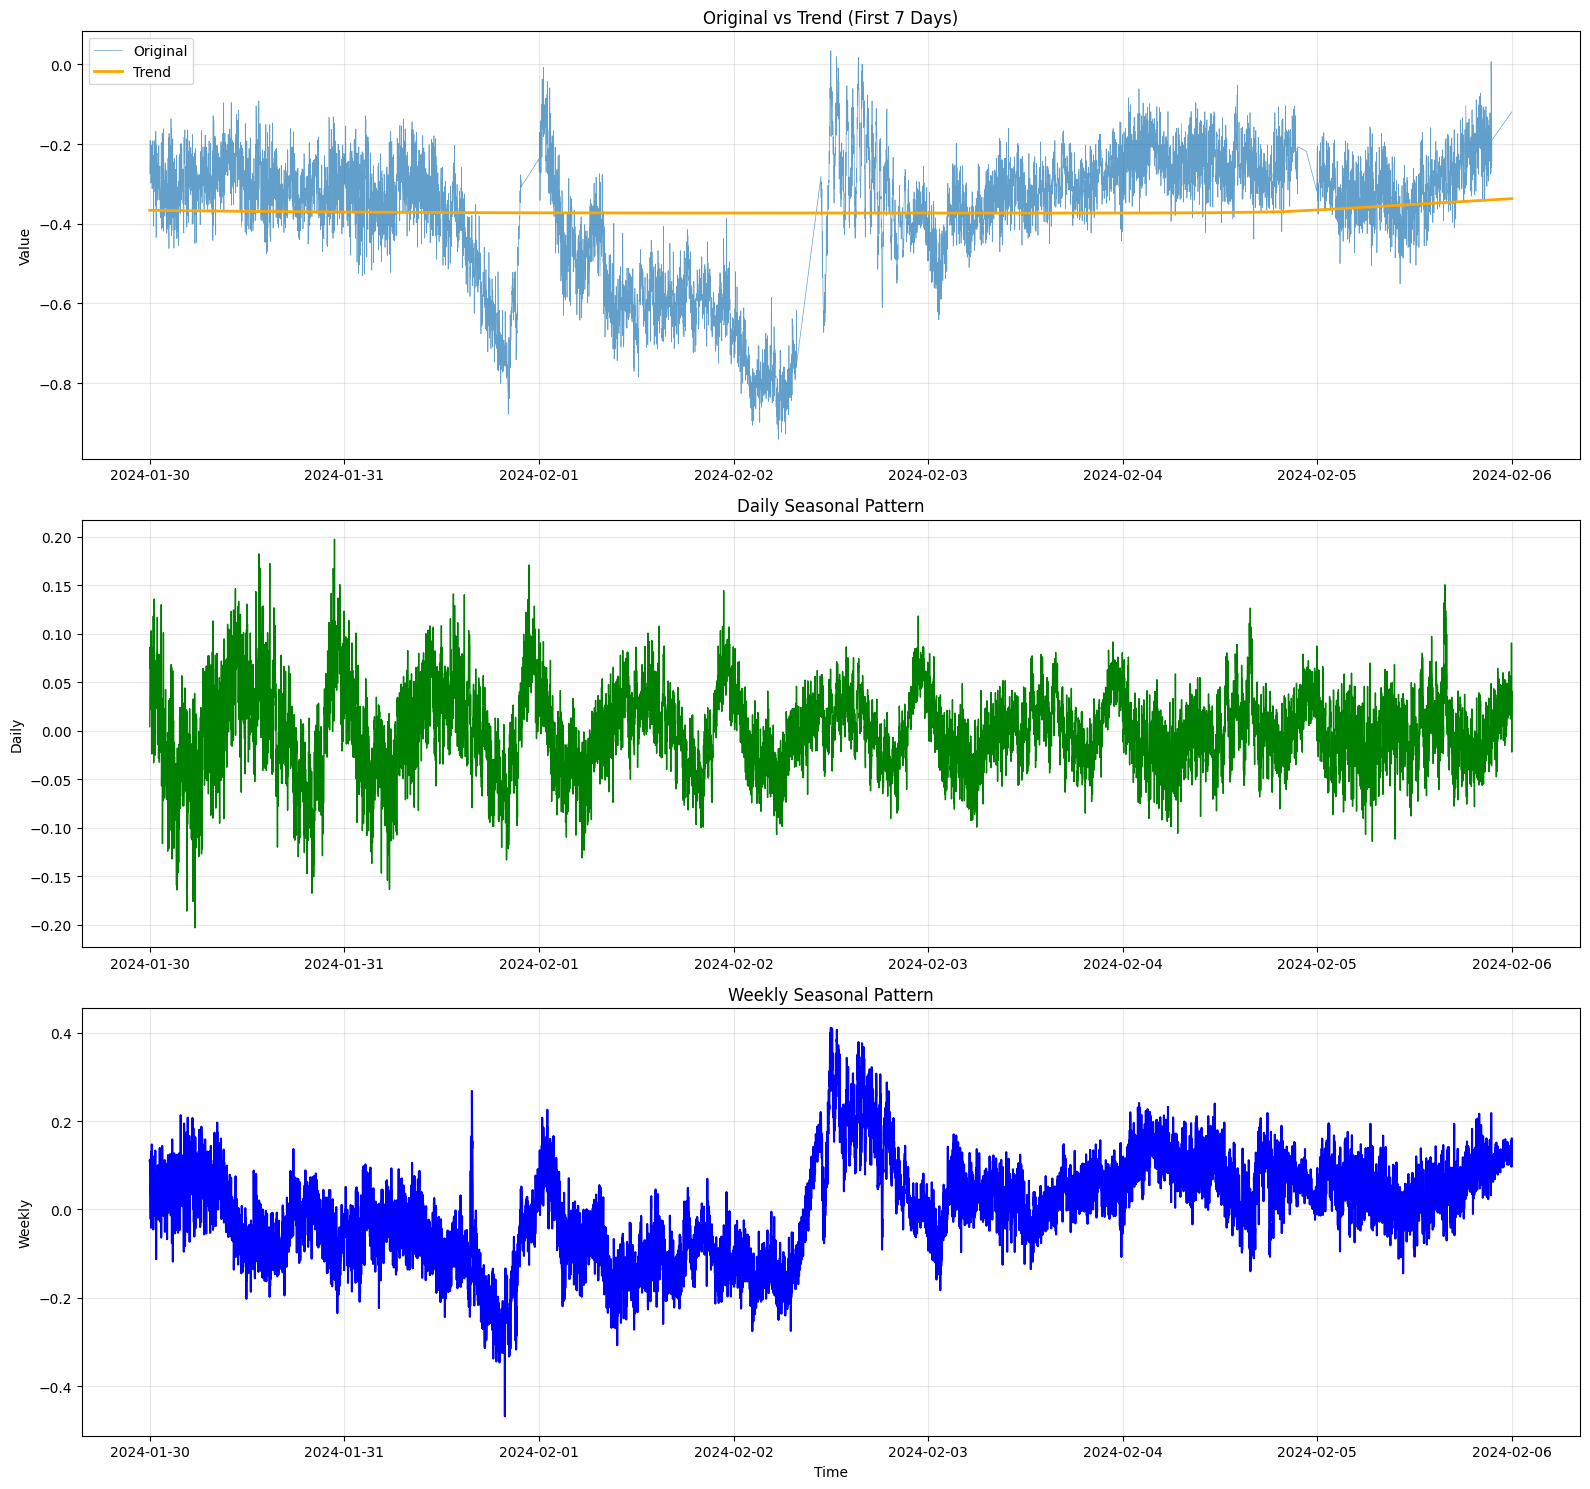

In [17]:
if df_decomposed is not None:
    start = df_decomposed['EventTime'].min()
    end = start + pd.Timedelta(days=7)
    
    df_week = df_decomposed[df_decomposed['EventTime'] <= end].copy()
    daily_col = f'seasonal_{daily_period}'
    weekly_col = f'seasonal_{weekly_period}' if use_weekly else None
    
    n_plots = 3 if use_weekly else 2
    fig, axes = plt.subplots(n_plots, 1, figsize=(16, 5*n_plots))
    
    idx = 0
    
    axes[idx].plot(df_week['EventTime'], df_week['Value'], linewidth=0.5, alpha=0.7, label='Original')
    axes[idx].plot(df_week['EventTime'], df_week['trend'], linewidth=2, color='orange', label='Trend')
    axes[idx].set_title('Original vs Trend (First 7 Days)')
    axes[idx].set_ylabel('Value')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    idx += 1
    
    axes[idx].plot(df_week['EventTime'], df_week[daily_col], linewidth=1, color='green')
    axes[idx].set_title('Daily Seasonal Pattern')
    axes[idx].set_ylabel('Daily')
    axes[idx].grid(True, alpha=0.3)
    idx += 1
    
    if use_weekly:
        axes[idx].plot(df_week['EventTime'], df_week[weekly_col], linewidth=1.5, color='blue')
        axes[idx].set_title('Weekly Seasonal Pattern')
        axes[idx].set_xlabel('Time')
        axes[idx].set_ylabel('Weekly')
        axes[idx].grid(True, alpha=0.3)
    else:
        axes[idx].set_xlabel('Time')
    
    plt.tight_layout()
    plt.savefig('patterns_7days.png', dpi=150)
    plt.show()
else:
    print("Cannot visualize - decomposition failed")

## Step 13: Save Results

In [ ]:
if df_decomposed is not None:
    print("Saving results...")
    print("="*80)
    
    safe_tag = selected_sensor.replace('/', '_').replace('\\', '_').replace(':', '_')
    
    # Save parquet
    parquet_file = f'decomposition_{safe_tag}_1min_full.parquet'
    df_decomposed.to_parquet(parquet_file, index=False)
    print(f"Saved: {parquet_file}")
    
    # Calculate variance breakdown
    seasonal_cols = [col for col in df_decomposed.columns if col.startswith('seasonal_')]
    
    total_var = df_decomposed['Value'].var()
    trend_var = df_decomposed['trend'].dropna().var()
    residual_var = df_decomposed['residual'].dropna().var()
    
    variance_dict = {
        'trend_pct': float(trend_var / total_var * 100),
        'residual_pct': float(residual_var / total_var * 100)
    }
    
    # Add seasonal variances
    total_seasonal_var = 0
    for col in seasonal_cols:
        period = int(col.split('_')[1])
        var = df_decomposed[col].dropna().var()
        variance_dict[f'seasonal_{period}_pct'] = float(var / total_var * 100)
        total_seasonal_var += var
    
    variance_dict['combined_seasonal_pct'] = float(total_seasonal_var / total_var * 100)
    
    # Create metadata
    metadata = {
        'sensor': selected_sensor,
        'duration': f'{(df_decomposed["EventTime"].max() - df_decomposed["EventTime"].min()).days:.1f} days',
        'data_points': len(df_decomposed),
        'resampling': {
            'frequency': '1 minute',
            'aggregation': 'mean'
        },
        'interpolation': {
            'method': 'time',
            'limit': 'none (all gaps interpolated)',
            'values_interpolated': int(interpolated_count)
        },
        'outlier_handling': outlier_metadata,
        'periods': {f'period_{p}': p for p in periods},
        'time_range': {
            'start': str(df_decomposed['EventTime'].min()),
            'end': str(df_decomposed['EventTime'].max())
        },
        'variance_explained': variance_dict
    }
    
    # Save metadata
    metadata_file = f'decomposition_{safe_tag}_1min_full.json'
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"Saved: {metadata_file}")
    
    # Print summary
    print("\nSummary:")
    print(f"  Sensor: {selected_sensor}")
    print(f"  Duration: {metadata['duration']} days")
    for col in seasonal_cols:
        period = int(col.split('_')[1])
        pct = variance_dict[f'seasonal_{period}_pct']
        pattern_name = 'daily' if period == 1440 else 'weekly' if period == 10080 else f'{period}min'
        print(f"  {pattern_name.capitalize()} seasonality: {pct:.2f}%")
    print(f"  Residual: {variance_dict['residual_pct']:.2f}%")
else:
    print("Cannot save - decomposition failed")